# BowieMobility - A data extraction and data visualization project about Germany's e-Mobility

This notebook extracts and visualizes data regarding Germany's e-mobility sector (specifically cars) having in mind the following

### 0.1. Research Questions

* Does the amount of newly built charging points in Germany keep track with the rising number of electric vehicles over time?
* Which interesting facts can be extracted from data of vehicle charging sessions, e.g. which car brand is charged the most?

### 0.1. The data

Thus, the following data were obtained:

| Data description | source | data format |timespan | resulting dataframe in this notebook |
|:-----------------|--------|-------------|---------|--------------------------------------|
| Charging stations within Germany as of May 2020 | [Bundesnetzagentur](https://www.bundesnetzagentur.de/DE/Sachgebiete/ElektrizitaetundGas/Unternehmen_Institutionen/HandelundVertrieb/Ladesaeulenkarte/Ladesaeulenkarte_node.html) | `.xlsx` |2008 - 2020 | `df_ch_st` |
| Number of yearly registered vehicles in Germany sorted by type of fuel (including electric) | [Kraftfahrtbundesamt](https://www.kba.de/DE/Statistik/Fahrzeuge/Neuzulassungen/Umwelt/n_umwelt_z.html) | `.html`-table | 2008 - 2018 | `df_reg_cars` |
| Charging sessions for electric vehicles in Germany | [CIDS API](https://mclouddocs.plugsurfing.com/index.html) (coop between Germany Ministry of Traffic and Plugsurfing GmbH | API | 2020-05-18 - 2020-06-18 | `df_chr_ses` |

All data which had to be downloaded are to be found in `./data`. The above mentioned dataframes are exported into `.pickle`-files, which are also stored there.


## 1. Retrieving the data

### 1.0. Importing necessary modules

In [1]:
import pandas as pd
import numpy as np
import requests
import json
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

### 1.1. Obtaining the dataframe for the charging stations

In [2]:

df = pd.read_excel('./data/charging_stations.xlsx', skiprows=5)

# Dropping key columns. They might be important later though, when joining with other df's along a unique identifier
df.drop(['Public Key1', 'Public Key2', 'Public Key3', 'Public Key4'], axis =1, inplace = True)

# Renaming (translating) column names
df.rename(columns = {'Betreiber': 'operator',
                     'Adresse' : 'address',
                     'Postleitzahl Ort' : 'zip-code',
                     'Bundesland' : 'state',
                     'Längengrad [DG]' : 'lat',
                     'Breitengrad [DG]' : 'lon',
                     'Inbetriebnahmedatum' : 'date_of_activation',
                     'Anschlussleistung [kW]' : 'charging_power',
                     'Art der Ladeeinrichtung' : 'type_of_charger',
                     'Anzahl Ladepunkte' : 'no_of_chargingpoints',
                     'Steckertypen1' : 'plugtype_1',
                     'Steckertypen2' : 'plugtype_2',
                     'Steckertypen3' : 'plugtype_3',
                     'Steckertypen4' : 'plugtype_4',
                    },
          inplace=True,            
         )

# Translating German words within the columns, thereby creating a dictionary first
trans_dict = {'Schnellladeeinrichtung' : 'fast charger',
             'Normalladeeinrichtung' : 'normal charger',
              'Steckdose' : 'plug',
              'Typ' : 'type',
              'Kupplung' : 'connector'
             }

df['type_of_charger'] = df['type_of_charger'].apply(lambda x : trans_dict[x])

def translator(x, trans_dict):
    x = str(x)
    if not x == np.nan:
        for k, v in trans_dict.items():
            if k in x:
                x = x.replace(k, v)
    return x

df['plugtype_1'] = df['plugtype_1'].apply(lambda x : translator(x, trans_dict))
df['plugtype_2'] = df['plugtype_2'].apply(lambda x : translator(x, trans_dict))
df['plugtype_3'] = df['plugtype_3'].apply(lambda x : translator(x, trans_dict))
df['plugtype_4'] = df['plugtype_4'].apply(lambda x : translator(x, trans_dict))

# Splitting the city column into two, containing the zip-code AND the city respectively
df['city'] = df['zip-code'].apply(lambda x : " ".join(x.split()[1:]))
df['zip-code'] = df['zip-code'].apply(lambda x :''.join(x.split()[:1]))

# Rearranging the order of columns, place 'city' column at 4th position
cols = df.columns.tolist()
cols = cols[0:2] + cols[-1:] + cols[2:-1]
df = df[cols]

# Store dataframe in another with appropriate variable name
df_ch_st = df

# Export dataframe to pickle
df_ch_st.to_pickle('./data/df_ch_st.pkl')

# Look at finished dataframe
df_ch_st.head(5)

,operator,address,city,zip-code,state,lat,lon,date_of_activation,charging_power,type_of_charger,no_of_chargingpoints,plugtype_1,P1 [kW],plugtype_2,P2 [kW],plugtype_3,P3 [kW],plugtype_4,P4 [kW]
0,DREWAG Stadtwerke Dresden GmbH,Ammonstraße 72,Dresden,01067,Sachsen,13.721480,51.048719,2019-11-26,175,fast charger,2,"DC connector Combo, DC CHAdeMO",150,AC plug type 2,22,nan,NaN,nan,NaN
1,Autohaus Melkus GmbH,Hamburger Straße 30,Dresden,01067,Sachsen,13.698890,51.059870,2019-01-28,44,normal charger,2,AC plug type 2,22,AC plug type 2,22,nan,NaN,nan,NaN
2,DREWAG Stadtwerke Dresden GmbH,Magdeburger Straße 12,Dresden,01067,Sachsen,13.720513,51.062423,2019-11-18,33,normal charger,4,AC plug type 2,22,AC Schuko,3.7,AC plug type 2,22.0,AC Schuko,3.7
3,DREWAG Stadtwerke Dresden GmbH,Ringstraße 0,Dresden,01067,Sachsen,13.744003,51.048741,2018-10-30,150,fast charger,1,"DC connector Combo, DC CHAdeMO",75,nan,NaN,nan,NaN,nan,NaN
4,DREWAG Stadtwerke Dresden GmbH,Ringstraße 0,Dresden,01067,Sachsen,13.743981,51.048716,2020-02-26,175,fast charger,2,"DC connector Combo, DC CHAdeMO",150,AC plug type 2,22,nan,NaN,nan,NaN


### 1.2. Obtaining the dataframe for the yearly newly registered vehicles (including electric)

In [3]:
# URL from Kraftfahrtbundesamt
url="https://www.kba.de/DE/Statistik/Fahrzeuge/Neuzulassungen/Umwelt/n_umwelt_z.html"

r = requests.get(url)

# Read html-table into df, thereby converting dot-seperated thousands and comma-seperated decimals
df_list = pd.read_html(r.text,
                       decimal=',',
                       thousands='.',
                      )
df = pd.DataFrame(df_list[0])

# Convert Year column into datetime format
df['Jahr'] = pd.to_datetime(df['Jahr'], format="%Y")

# Translating German column names to English
col_names = df.columns.to_list()
engl_cols = ['year',
             'gasoline',
             'diesel',
             'liquid_gas',
             'natural_gas',
             'electric',
             'hybrid_total',
             'plug_in_of_hybrid',
             'total',
            ]

df= df.rename(columns={k:v for k,v in zip(col_names,engl_cols)})

# Setting '-' entries in plug-in-hybrid column to NaN
df['plug_in_of_hybrid'] = df['plug_in_of_hybrid'].apply(lambda x: int(x) if x.isnumeric() else np.nan)

# Store dataframe in another with appropriate variable name
df_reg_cars = df

# Export dataframe to pickle
df_reg_cars.to_pickle('./data/df_reg_cars.pkl')

# Look at finished dataframe
df_reg_cars.head(5)

,year,gasoline,diesel,liquid_gas,natural_gas,electric,hybrid_total,plug_in_of_hybrid,total
0,2009-01-01,2608767,1168633,11083,10062,162,8374,NaN,3807175
1,2010-01-01,1669927,1221938,8154,4982,541,10661,NaN,2916260
2,2011-01-01,1651637,1495966,4873,6283,2154,12622,NaN,3173634
3,2012-01-01,1555241,1486119,11465,5215,2956,21438,408.0,3082504
4,2013-01-01,1502784,1403113,6257,7835,6051,26348,1385.0,2952431


### 1.3. Obtaining the dataframe for electric vehicle charging sessions

Get the stations:

In [4]:
api_url = "https://api.plugsurfing.com/mfund/stations"

# Sending request to API
response = requests.get(api_url)
results = response.json()
df = pd.DataFrame(results)

connectors_into_df = pd.concat([pd.DataFrame(x) for x in df['connectors']], keys=df[:]).reset_index(level=1, drop=True).reset_index()

connectors_list = connectors_into_df.values.tolist()

Get the sessions:

### Extracting 'vehicleUsage_df' from 'sessions' API 

In [5]:
response = requests.get("https://api.plugsurfing.com/mfund/sessions")
sessions_data=response.json()

vehicleUsage_dict = sessions_data['vehicleUsage']

vehicleUsage_df=pd.DataFrame(vehicleUsage_dict)

#change column 'name' to "type-of-cars" and "percentage" to "usage-coefficient"
vehicleUsage_df = vehicleUsage_df.rename(columns={'name':'type-of-cars', 'percentage':'usage-coefficient'})

vehicleUsage_df.sort_values("usage-coefficient", ascending=False).reset_index(drop=True)

# Store dataframe in another with appropriate variable name
df_chr_st = vehicleUsage_df

# Export dataframe to pickle
df_chr_st.to_pickle('./data/df_chr_st.pkl')

# Look at finished dataframe
df_chr_st.head(5)

,type-of-cars,usage-coefficient
0,unknown,23.404118
1,Renault Kangoo,0.127821
2,Renault ZOE,7.959020
3,Tesla Model S,2.098968
4,Smart ED4 Forfour,0.716783


## 2. Plotting

### 2.1. Plotting the most charged vehicles, using the sessions dataset

For the charging sessions data set, let's visualize which car brand charges the most, that is, whose car brands' cars are charged the most

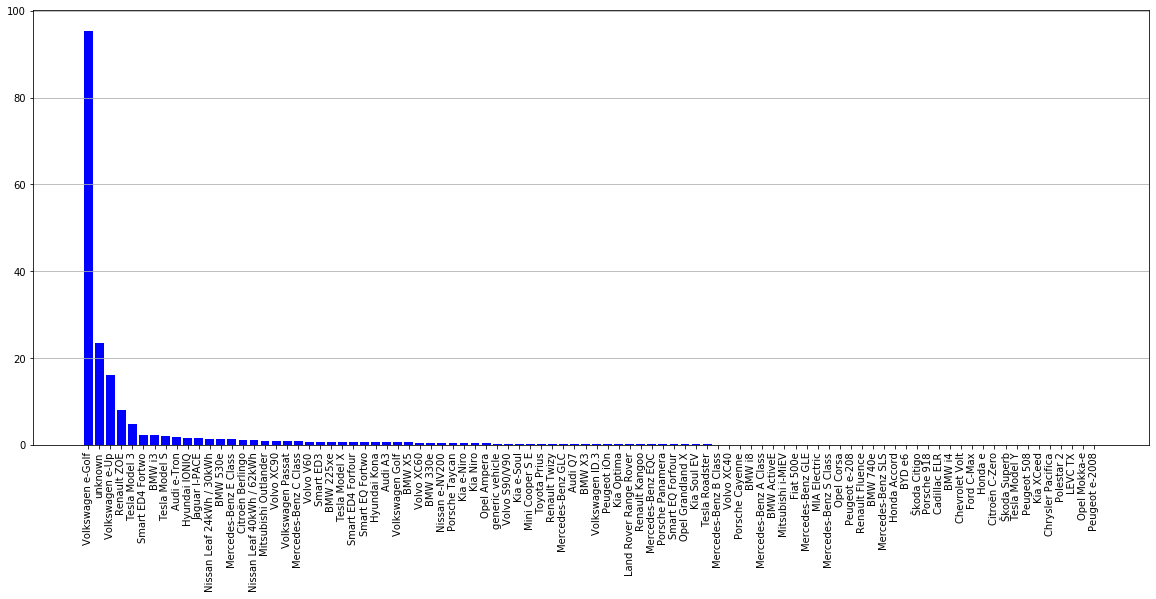

In [6]:
fig, ax = plt.subplots(figsize=(20,8))
plt.bar(df_chr_st.sort_values('usage-coefficient', ascending=False)["type-of-cars"],
        df_chr_st.sort_values('usage-coefficient', ascending=False)["usage-coefficient"],
        color = "blue",
       )
ax.tick_params(axis='x', labelrotation=90)
ax.grid(axis='y')

### 2.2. Plotting the time curves for electric vehicles and charging stations over the years

Now, we first have to gather the number of charging stations as well as the number of vehicles each summed up over every year. Both in a normal way (which represents the yearly *growth*) as well as accumulated over the years. Later, we will plot each pair of these in one diagram.

In [7]:
# Dataframe of cummulative charging points over the years from 2008 until 2020
df_cumsum_ch_pts = df_ch_st.groupby(df_ch_st.date_of_activation.dt.year).agg('sum').cumsum()[['no_of_chargingpoints']]
df_cumsum_ch_pts.reset_index(level=0, inplace=True)
df_cumsum_ch_pts['date_of_activation'] = pd.to_datetime(df_cumsum_ch_pts['date_of_activation'], format="%Y")

In [8]:
# Dataframe of newly yearly build charging points
df_growth_ch_pts = df_ch_st.groupby(df_ch_st.date_of_activation.dt.year).agg('sum')[['no_of_chargingpoints']]
df_growth_ch_pts.reset_index(level=0, inplace=True)
df_growth_ch_pts['date_of_activation'] = pd.to_datetime(df_growth_ch_pts['date_of_activation'], format="%Y")

In [9]:
# Df of accumulated yearly registered e-vehicles
df_cumsum_veh = df_reg_cars[['electric']].cumsum()
df_cumsum_veh['year'] = df_reg_cars['year']

In [10]:
# Dataframe of newly yearly registered e-vehicles
df_growth_veh = df_reg_cars[['year','electric']]

Plotting:

Text(0, 0.5, 'Count')

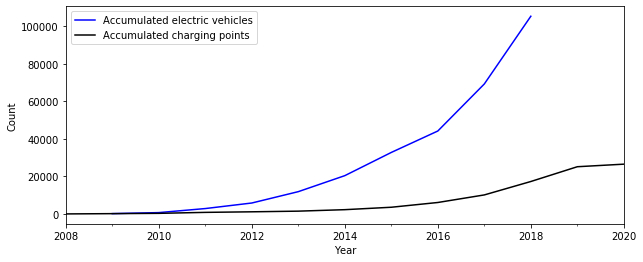

In [11]:
fig1, ax1 = plt.subplots(figsize=(10,4))
df_cumsum_veh.plot(x='year',
                   y='electric',
                   ax=ax1,
                   color='blue'
                  )
df_cumsum_ch_pts.plot(x='date_of_activation',
                      y='no_of_chargingpoints',
                      ax=ax1,
                      color='black'
                     )
ax1.legend(['Accumulated electric vehicles', 'Accumulated charging points'])
ax1.set_xlabel('Year')
ax1.set_ylabel('Count')

Text(0, 0.5, 'Count')

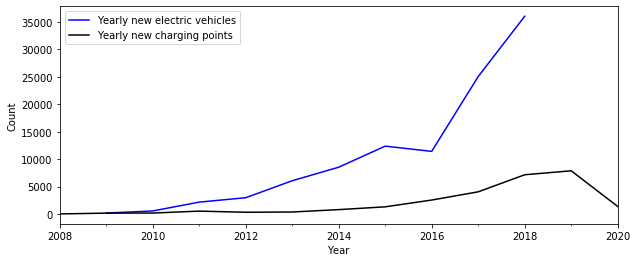

In [12]:
fig1, ax1 = plt.subplots(figsize=(10,4))
df_growth_veh.plot(x='year',
                   y='electric',
                   ax=ax1,
                   color='blue'
                  )
df_growth_ch_pts.plot(x='date_of_activation',
                      y='no_of_chargingpoints',
                      ax=ax1,
                      color='black'
                     )
ax1.legend(['Yearly new electric vehicles', 'Yearly new charging points'])
ax1.set_xlabel('Year')
ax1.set_ylabel('Count')

# 3.0 Limitations and conclusions

It is necessary to mention a few things about the data before conclusions from these plots can be made:

* The charging stations data only include those registered at the *Bundesnetzagentur* and only of those operators, who have finished the registering process and have agreed on having their station published in that database. A growing number of users of electric cars are known to charge their vehicles using a private charger, which is not listed in that database.
* The accumulated values both for cars as well as the charging stations don't take into account possible decommissioning of both. We assume though, that the share for decommissioned cars and chargers among all cars and chargers remain in low percentage numbers over only a timespan of 10 years.
* To our knowledge, the sessions data span only over the last 30 days. We can not make an informed statement about which car is charged in which timespan of the year and/or if there's any correlation between these two values. This is the reason, why wouldn't want the above plot to be understood as a general statement about "the most charged cars over a year"

Nevertheless, regarding the research question mentioned under **0.1.** it can be said, that the data indicate, that the growth of registered electric vehicles in Germany is faster than the building of open accessible charging stations and could pose a problem in the future to provide the necessary charging infrastructure for the growing demand of electric vehicles. This observation is in line with reports in [German media](https://www.dw.com/en/german-e-cars-still-hampered-by-lack-of-charging-stations/a-45245116)

# 4.0 Possible further questions and improvements

The dataframe `df_ch_st` contains several more important data that could reveal interesting insights, such as
* the temporal development of the numbers of charges per charging station
* the temporal development of the chargers for each German state
* the temporal development of the average charging power per each charging station

Also, the dataframe `df_reg_cars`, whose data only reach up until 2018, could be enriched by more data up until the present month, which are also availabe on the page of the Kraftfahrtbundesamt (with montly resolution). This will fill the 2 year gap in the plots between 2018 and 2020.